<a href="https://colab.research.google.com/github/jakewalter/fracture_cv/blob/main/dem_fracture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from osgeo import gdal
#import poly_point_isect

import cv2


from skimage.transform import  probabilistic_hough_line
from skimage.feature import canny
#from skimage import data


import math

In [ ]:
def slope(line):
    m = 0
    x1 = line[0][0]
    x2 = line[1][0]
    y1 = line[0][1]
    y2 = line[1][1]    
    b = (x2 - x1)
    d = (y2 - y1)
    if b != 0:
        m = (d)/(b) 

    return m

def calc_strikedip(pts):
    ptA, ptB, ptC = pts[0], pts[1]
    x1, y1, z1 = float(ptA[0]), float(ptA[1]), float(ptA[2])
    x2, y2, z2 = float(ptB[0]), float(ptB[1]), float(ptB[2])
    x3, y3, z3 = float(ptC[0]), float(ptC[1]), float(ptC[2])


    u1 = float(((y1 - y2) * (z3 - z2) - (y3 - y2) * (z1 - z2)))
    u2 = float((-((x1 - x2) * (z3 - z2) - (x3 - x2) * (z1 - z2))))
    u3 = float(((x1 - x2) * (y3 - y2) - (x3 - x2) * (y1 - y2)))

    '''
    Calculate pseudo eastings and northings from origin
    these are actually coordinates of a new point that represents
    the normal from the plane's origin defined as (0,0,0).
    
    If the z value (u3) is above the plane we first reverse the easting
    then we check if the z value (u3) is below the plane, if so
    we reverse the northing. 
    
    This is to satisfy the right hand rule in geology where dip is always
    to the right if looking down strike. 
    '''
    if u3 < 0:
        easting = u2
    else:
        easting = -u2

    if u3 > 0:
        northing = u1
    else:
        northing = -u1
    
    if easting >= 0:
        partA_strike = math.pow(easting, 2) + math.pow(northing, 2)
        strike = math.degrees(math.acos(northing / math.sqrt(partA_strike)))
    else:
        partA_strike = northing / math.sqrt(math.pow(easting, 2) + math.pow(northing, 2))
        strike = math.degrees(2 * math.pi - math.acos(partA_strike))

    # determine dip
    print(strike, 'strike')
    part1_dip = math.sqrt(math.pow(u2, 2) + math.pow(u1, 2))
    part2_dip = math.sqrt(math.pow(u1,2) + math.pow(u2,2) + math.pow(u3,2))
    dip = math.degrees(math.asin(part1_dip / part2_dip))

    return strike, dip




def rose_plot(ax, angles, bins=36, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='k', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)


def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal

    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    """
    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]


def find_nearest(x,y,topo,x1,y1):
    #array = np.asarray(array)
    absx = np.abs(x - x1)
    absy = np.abs(y - y1)
    c_idx = (np.maximum(absx,absy)).argmin()
    topoval = topo.flat[c_idx]
    return topoval

def loadgrd(file):
    geo = gdal.Open(file)
    arr = geo.ReadAsArray()
    #drv = geo.GetDriver()
    
    band = geo.GetRasterBand(1) #bands start at one
    arr = band.ReadAsArray().astype(np.float)
    #print(drv.GetMetadataItem('DMD_LONGNAME'))
    # (x_index1, y_index1) = np.shape(arr)
    # x_index=np.arange(0,x_index1)
    # y_index=np.arange(0,y_index1)
    
    # (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo.GetGeoTransform()
    # x_coords = x_index*x_size + upper_left_x + (x_size / 2) #add half the cell size
    # y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point
    topo = arr
    topo[topo<-9000] = np.nan
#    x,y=np.meshgrid(np.flipud(x_coords),y_coords)
    gt = geo.GetGeoTransform()
    xres = gt[1]
    yres = gt[5]
    X = np.arange(gt[0], gt[0] + arr.shape[1]*xres-xres/2, xres)
    Y = np.arange(gt[3], gt[3] + arr.shape[0]*yres-xres/2, yres)
     # creation of a simple grid without interpolation
    x, y = np.meshgrid(X, Y)
    #fig = plt.figure(frameon=False)
    #plt.imshow(x_coords,y_coords,topo, cmap=cm.BrBG_r)
    #plt.axis('off')
    #cbar = plt.colorbar(shrink=0.75)
    #cbar.set_label('meters')
    #plt.savefig('basement.png', dpi=300, bbox_inches='tight')
    #plt.show()
    return topo,x,y


In [ ]:

!wget https://jakewalter.mynetgear.com/data/fdem.zip
!unzip fdem.zip

--2023-04-06 16:20:21--  https://jakewalter.mynetgear.com/data/fdem.zip
Resolving jakewalter.mynetgear.com (jakewalter.mynetgear.com)... 75.3.206.131
Connecting to jakewalter.mynetgear.com (jakewalter.mynetgear.com)|75.3.206.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254597607 (243M) [application/zip]
Saving to: ‘fdem.zip.1’

fdem.zip.1          100%[===================>] 242.80M  22.7MB/s    in 11s     

2023-04-06 16:20:32 (22.0 MB/s) - ‘fdem.zip.1’ saved [254597607/254597607]

Archive:  fdem.zip
replace fdem.asc? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
print(os.getcwd())
%ls

/content
fdem.asc          fdem.asc.ovr  fdem.zip    sample_data/
fdem.asc.aux.xml  fdem.asc.xml  fdem.zip.1  temp.png


<ipython-input-6-34ad0aa5a860>:172: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = band.ReadAsArray().astype(np.float)


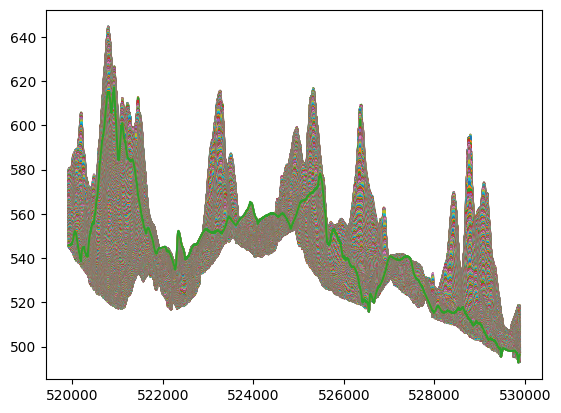

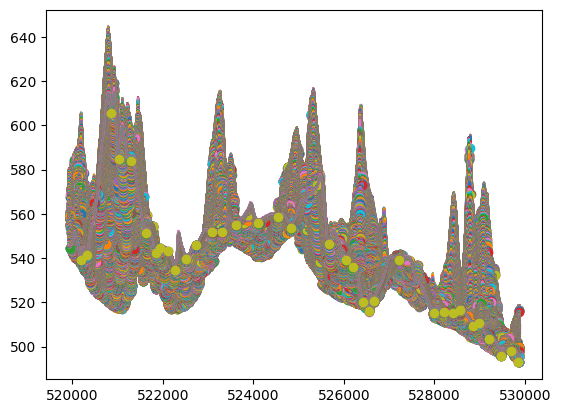

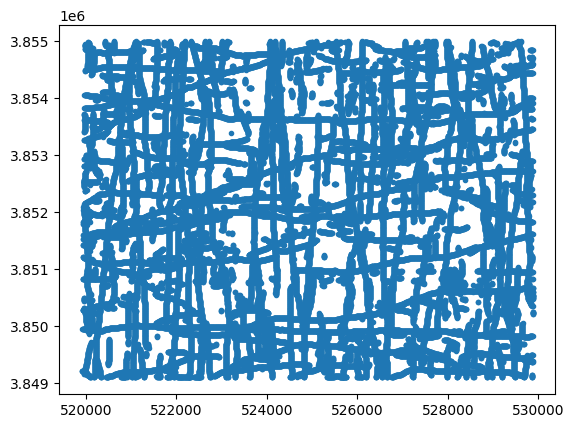

In [ ]:
topo,x,y = loadgrd('/content/fdem.asc')
#ndvi,x1,y1 = loadgrd('/home/jwalter/Dropbox/Meers_Jake_Netra/ndvi/ndvi.asc')
smoothn = 60
skips = 5
# from mpl_toolkits.mplot3d import axes3d, Axes3D
# # fig = plt.figure()
# # ax = Axes3D(fig)
# # surf = ax.plot_surface(x1,y1,ndvi, cmap='Greens',antialiased=True,vmin=0,vmax=1)

# fig = plt.figure()
# ax = Axes3D(fig)
# surf = ax.plot_surface(y,x,topo, cmap='gray',antialiased=True,vmin=-10000,vmax=10000)

xb = np.array([])
yb = np.array([])
zb = np.array([])

#data = np.zeros( (topo.shape[0],topo.shape[1],3), dtype=np.uint8 )
data = np.zeros((topo.shape[0],topo.shape[1]))
for idx1,val in enumerate(x[::skips,0]):
    #print(val,idx1)
    #print(x[idx1])
    sline = topo[idx1,:]
    plt.figure(0)
    plt.plot(x[idx1,:],sline)
    b = (np.diff(np.sign(np.diff(smooth(sline,smoothn)))) > 0).nonzero()[0] + 1 # local min
    plt.figure(1)
    #plt.plot(x[idx1,:],np.gradient(sline,1))
    plt.plot(x[idx1,:],sline)
    plt.plot(x[idx1,:],smooth(sline,smoothn))
    plt.plot(x[idx1,b], sline[b], "o", label="min")
    xb = np.append(xb,x[idx1*skips,b])
    yb = np.append(yb,y[idx1*skips,b])
    zb = np.append(zb, sline[b])
    data[idx1*skips,b] = [255]
    
for idx2,val in enumerate(x[0,::skips]):
    #print(val,idx2)
    #print(x[idx1])

    sline = topo[:,idx2]
#    plt.figure(0)
#    plt.plot(x[idx1,:],sline)
    b = (np.diff(np.sign(np.diff(smooth(sline,smoothn)))) > 0).nonzero()[0] + 1 # local min
#    plt.figure(1)
#    #plt.plot(x[idx1,:],np.gradient(sline,1))
#    plt.plot(x[idx1,:],sline)
#    plt.plot(x[idx1,:],smooth(sline,smoothn))
#    plt.plot(x[idx1,b], sline[b], "o", label="min")
    xb = np.append(xb,x[b,idx2*skips])
    yb = np.append(yb,y[b,idx2*skips])
    zb = np.append(zb, sline[b])
    data[b,idx2*skips] = [255]
plt.figure()
plt.plot(xb,yb,'.')

Text(0.5, 1.0, 'OpenCV Hough')

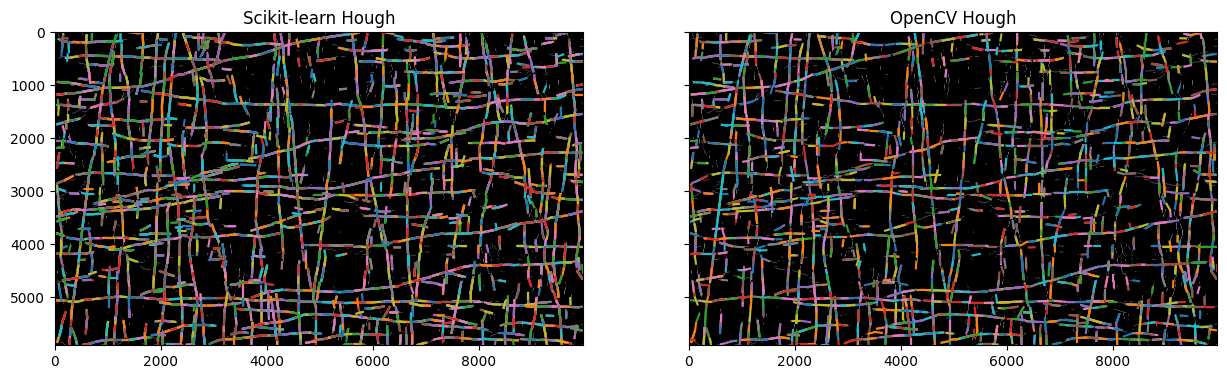

In [ ]:
#make the data points into an image
# Line finding using the Probabilistic Hough Transform
# https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html
image = data
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=100,
                                 line_gap=20)
#lines_lsd = lsd(image)

#temp = cv2.dilate(image)
cv2.imwrite('temp.png',image)
img = cv2.imread('temp.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# edges = canny(image, 2, 1, 25)
# edges1 = cv2.Canny(gray,1,25,apertureSize = 7)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilate = cv2.dilate(gray, kernel, iterations=2)
#lines_lsd = lsd(dilate)
lines_sci = probabilistic_hough_line(dilate, threshold=15, line_length=100,
                                 line_gap=20)



rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
#https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html#
lines = cv2.HoughLinesP(dilate, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

#lines = cv2.HoughLinesP(dilate,cv2.HOUGH_PROBABILISTIC, np.pi/180, 30, minLineLength,maxLineGap)
# plt.figure()
# plt.imshow(dilate)
# for line in lines:
#     plt.plot((line[0][0], line[0][2]), (line[0][1], line[0][3]))
    
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(dilate, cmap=cm.gray)
for line in lines_sci:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[0].set_title('Scikit-learn Hough')

ax[1].imshow(dilate,cmap=cm.gray)
for line in lines:
    ax[1].plot((line[0][0], line[0][2]), (line[0][1], line[0][3]))
ax[1].set_title('OpenCV Hough')

<ipython-input-11-9b12650e0567>:4: RuntimeWarning: divide by zero encountered in long_scalars
  azim = np.arctan((lines1[1][0] - lines1[0][0])/(lines1[1][1] - lines1[0][1]))
<ipython-input-11-9b12650e0567>:20: RuntimeWarning: divide by zero encountered in int_scalars
  azim = np.arctan((lines1[2] - lines1[0])/(lines1[3] - lines1[1]))


Text(0.5, 1.0, 'Probabilistic Hough lines')

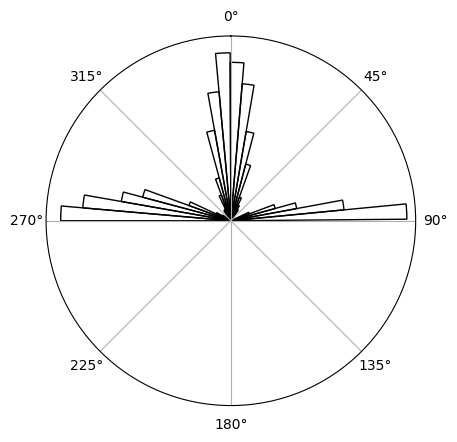

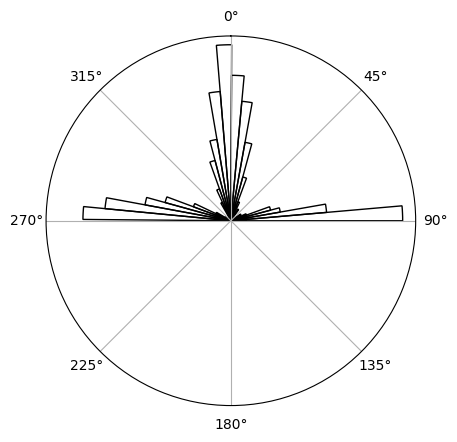

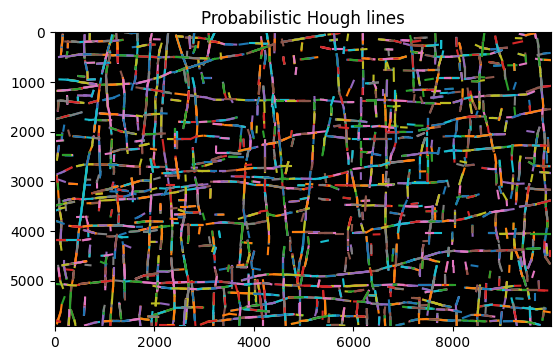

In [ ]:



lines_sci = np.array(lines_sci)
azimd = []
for lines1 in lines_sci:
    azim = np.arctan((lines1[1][0] - lines1[0][0])/(lines1[1][1] - lines1[0][1]))

    azimd.append(np.degrees(azim))
    
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
rose_plot(ax, np.radians(np.array(azimd)))
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")



###### Lines from opencv
lines = np.array(lines)
azimd = []
for lines1a in lines:
    lines1 = lines1a[0]
    azim = np.arctan((lines1[2] - lines1[0])/(lines1[3] - lines1[1]))

    azimd.append(np.degrees(azim))
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
rose_plot(ax, np.radians(np.array(azimd)), color='k')
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")    




fig, ax = plt.subplots(1, 1)
# ax = axes.ravel()
ax.imshow(line_image)
# for line in lines:
#     p0, p1 = line
#     ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

for line in lines:
    ax.plot((line[0][0], line[0][2]), (line[0][1], line[0][3]))
ax.set_xlim((0, image.shape[1]))
ax.set_ylim((image.shape[0], 0))
ax.set_title('Probabilistic Hough lines')
# ax[1].polar(ax, np.radians(np.array(azimd)))
# ax[1].set_theta_direction(-1)
# ax[1].set_theta_zero_location("N")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


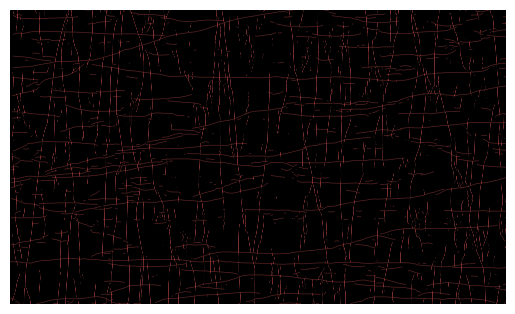

In [ ]:

import cv2

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
dilate = cv2.dilate(gray, kernel, iterations=2)

!pip install skan

#https://skeleton-analysis.org/stable/index.html
from skimage import morphology
from skan.pre import threshold
binary0 = threshold(dilate)
skeleton0 = morphology.skeletonize(binary0)
from skan import draw
fig, ax = plt.subplots()
draw.overlay_skeleton_2d(dilate, skeleton0, dilate=1, axes=ax);



In [ ]:

from skan.csr import skeleton_to_csgraph

pixel_graph, coordinates = skeleton_to_csgraph(skeleton0)


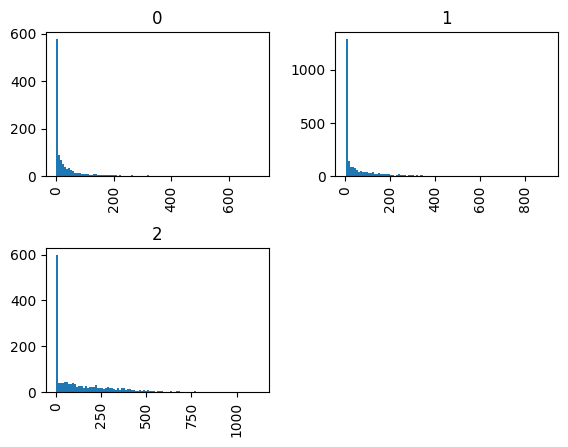

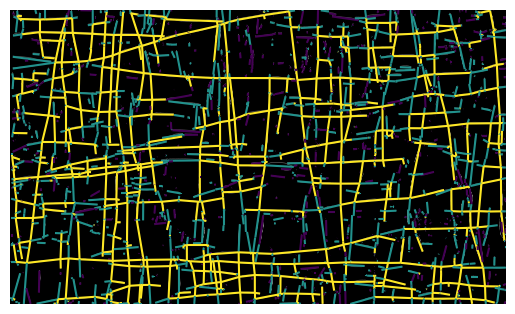

In [ ]:
from skan import Skeleton, summarize
branch_data = summarize(Skeleton(skeleton0, spacing=1))
branch_data.head()
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

draw.overlay_euclidean_skeleton_2d(dilate, branch_data, skeleton_color_source='branch-type');